In [1]:
librarian::shelf(tidyverse, tidymodels, DataExplorer, GGally, corrplot, plotly, viridis,
pROC, randomForest, factoextra, cluster, ggthemes, ggridges, scales, vcd, kableExtra, DT, 
MASS, Rtsne, tsne, umap, conflicted)

In [23]:
# Set custom theme

theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

theme_set(theme_custom())



# 1. Introduction

This document presents an intensive exploratory loan_data analysis (EDA) and statistical analysis of a loan default loan_dataset. The goal is to uncover patterns, relationships, and insights that can help predict loan defaults. The analysis includes:

- loan_data preprocessing and cleaning
- Univariate analysis with advanced visualizations
- Bivariate and multivariate analysis
- Correlation analysis with sophisticated visualizations
- Feature importance and selection
- Statistical modeling and predictive analysis
- Advanced dimensionality reduction and visualization techniques

Let's begin by loading and examining the loan_dataset.

# 2. loan_data Loading and Initial Exploration

In [2]:
conflicted::conflicts_prefer(dplyr::select)
tidymodels_prefer()

[conflicted] Will prefer dplyr::select over any other package.


In [3]:
loan_data <- read_csv("dataset/Loan_Default.csv")

Rows: 148670 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): loan_limit, Gender, approv_in_adv, loan_type, loan_purpose, Credit...
dbl (13): ID, year, loan_amount, rate_of_interest, Interest_rate_spread, Upf...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
loan_data %>% 
  janitor::clean_names() %>%
  select(-id) -> loan_data


In [36]:
# Split the data to 20000 observations for quick modelling before upscaling
library(caTools)

set.seed(123) # For reproducibility
sample_ratio <- 20000 / nrow(loan_data_imputed)

# Create a stratified sample index
split_index <- sample.split(loan_data$status, SplitRatio = sample_ratio)

# Extract the sample
sampled_data <- loan_data[split_index,]

# Verify sample size and distribution
nrow(sampled_data)
table(sampled_data$status) / nrow(sampled_data)


      0       1 
0.75355 0.24645 

In [38]:
cat("Dimensions of the loan_dataset", dim(sampled_data)[1], "rows and ", dim(sampled_data)[2], " columns")

Dimensions of the loan_dataset 20000 rows and  33  columns

In [39]:
head(sampled_data)

# A tibble: 6 × 33
   year loan_limit gender approv_in_adv loan_type loan_purpose credit_worthiness
  <dbl> <fct>      <fct>  <fct>         <fct>     <fct>        <fct>            
1  2019 cf         Joint  pre           type1     p1           l1               
2  2019 cf         Joint  pre           type1     p3           l1               
3  2019 cf         Joint  nopre         type2     p4           l1               
4  2019 cf         Female nopre         type1     p4           l1               
5  2019 cf         Joint  nopre         type2     p1           l1               
6  2019 cf         Female nopre         type1     p3           l1               
# ℹ 26 more variables: open_credit <fct>, business_or_commercial <fct>,
#   loan_amount <dbl>, rate_of_interest <dbl>, interest_rate_spread <dbl>,
#   upfront_charges <dbl>, term <dbl>, neg_ammortization <fct>,
#   interest_only <fct>, lump_sum_payment <fct>, property_value <dbl>,
#   construction_type <fct>, occupancy_type <fct>, 

In [40]:
skimr::skim(sampled_data) %>% 
  as.tibble() %>% 
  kable(caption = "Summary Statistics of the loan loan_data")



Table: Summary Statistics of the loan loan_data

|skim_type |skim_variable             | n_missing| complete_rate|factor.ordered | factor.n_unique|factor.top_counts                          | numeric.mean|   numeric.sd|   numeric.p0|  numeric.p25|  numeric.p50|  numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------------------|---------:|-------------:|:--------------|---------------:|:------------------------------------------|------------:|------------:|------------:|------------:|------------:|------------:|------------:|:------------|
|factor    |loan_limit                |       438|       0.97810|FALSE          |               2|cf: 18221, ncf: 1341                       |           NA|           NA|           NA|           NA|           NA|           NA|           NA|NA           |
|factor    |gender                    |         0|       1.00000|FALSE          |               4|Mal: 5730, Joi: 5485, Sex: 5027, Fem: 3758 |           NA|           NA|           NA|

In [41]:
# Convert all character loan_amounts to factors

sampled_data <- sampled_data %>% mutate_if(is.character, as.factor)

## Missing loan_data Analysis


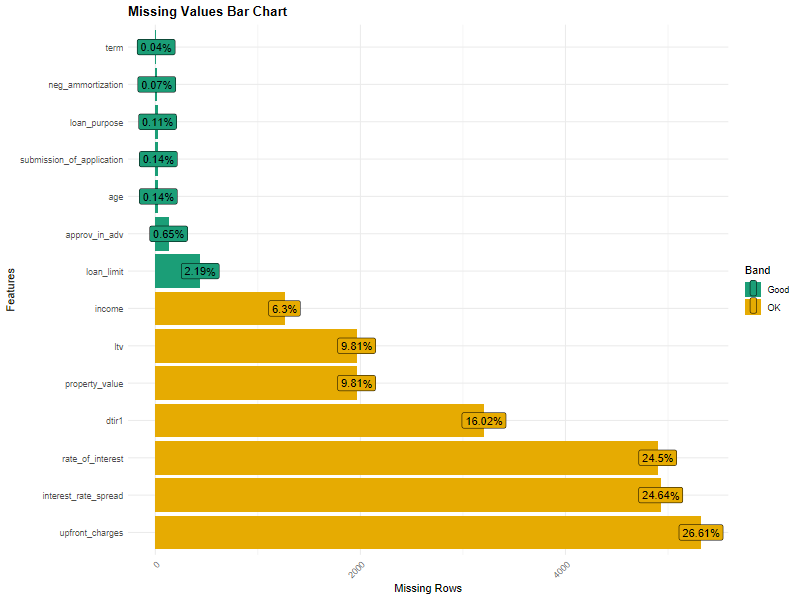

In [42]:
plot_missing(sampled_data, missing_only = TRUE, title = "Missing Values Bar Chart") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"))

In [43]:
# Function to find mode
find_mode <- function(x) {
  uniq_x <- unique(na.omit(x))
  uniq_x[which.max(tabulate(match(na.omit(x), uniq_x)))]
}

# Impute missing values
sampled_data_imputed <- sampled_data %>%
  mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .)),
         across(where(is.factor), ~as.factor(ifelse(is.na(.), as.character(find_mode(.)), as.character(.)))))

# Check if imputation was successful
any(is.na(sampled_data_imputed))

[1] FALSE

In [34]:
miss_recipe <- recipe(status ~ ., sampled_data) %>% 
  step_impute_knn(all_numeric_predictors()) %>% 
  prep()

# 3. Univariate Analysis

## 3.1 Distribution of Numeric loan_amounts

In [25]:
loan_data$status <- as.factor(loan_data$status)

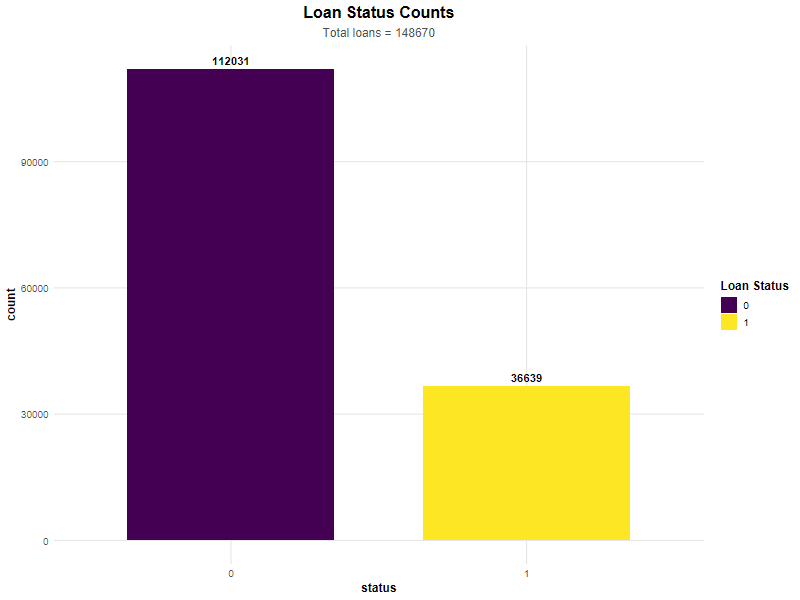

In [26]:
status_counts <- loan_data %>% 
  count(status) %>% 
  mutate(percentage = n / sum(n) * 100)

ggplot(loan_data, aes(status, fill = status)) +
    geom_bar(width = 0.7) +
    geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
    scale_fill_viridis_d(option = "D") +
  labs(
      title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(loan_data)),
      fill = "Loan Status"
    ) +
  theme_custom()

In [29]:
library(gridExtra)
numeric_cols <- loan_data %>% 
  select(-year) %>% 
  select_if(is.numeric) %>% 
  names()

In [32]:
numeric_features <- loan_data %>% 
  select(all_of(numeric_cols), status) %>% 
  pivot_longer(values_to = "values",
names_to = "features", 
cols = status)

colSums(is.na(numeric_features))

         loan_amount     rate_of_interest interest_rate_spread 
                   0                36439                36639 
     upfront_charges                 term       property_value 
               39642                   41                15098 
              income         credit_score                  ltv 
                9150                    0                15098 
               dtir1             features               values 
               24121                    0                    0 

Warning messages:
1: `aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
3: Removed 36439 rows containing non-finite outside the scale range
(`stat_density()`). 
4: Removed 36639 rows containing non-finite outside the scale range
(`stat_density()`). 
5: Removed 39642 rows containing non-finite outside the scale range
(`stat_density()`). 
6: Removed 41 rows containing non-finite outside the scale range
(`stat_density()`). 
7: Removed 15098 rows containing non-finite outside the scale range
(`stat_density()`). 
8: Re

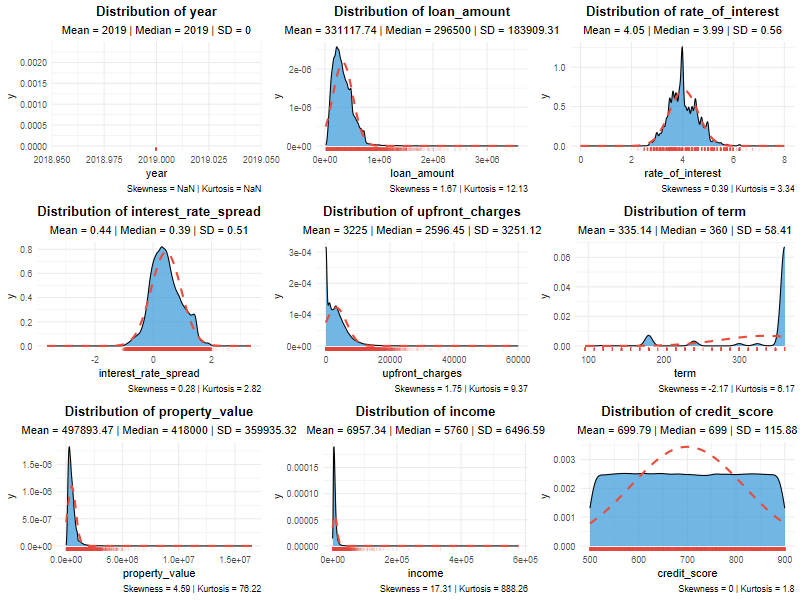

In [12]:

advanced_density_plot <- function(data, variable) {
  p <- ggplot(data, aes_string(x = variable)) +
    geom_density(fill = "#3498db", alpha = 0.7) +
    geom_rug(alpha = 0.1, color = "#e74c3c") +
    stat_function(
      fun = function(x) dnorm(x, mean = mean(data[[variable]], na.rm = TRUE), 
                              sd = sd(data[[variable]], na.rm = TRUE)),
      color = "#e74c3c", linetype = "dashed", size = 1
    ) +
    labs(
      title = paste("Distribution of", variable),
      subtitle = paste(
        "Mean =", round(mean(data[[variable]], na.rm = TRUE), 2),
        "| Median =", round(median(data[[variable]], na.rm = TRUE), 2),
        "| SD =", round(sd(data[[variable]], na.rm = TRUE), 2)
      ),
      caption = paste(
        "Skewness =", round(moments::skewness(data[[variable]], na.rm = TRUE), 2),
        "| Kurtosis =", round(moments::kurtosis(data[[variable]], na.rm = TRUE), 2)
      )
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5),
      plot.caption = element_text(hjust = 1)
    )
  
  return(p)
}

# Create density plots for the first 9 numeric variables
if(length(numeric_cols) > 0) {
  plot_list <- lapply(numeric_cols[1:min(9, length(numeric_cols))], 
                     function(col) advanced_density_plot(loan_data, col))
  do.call(grid.arrange, c(plot_list, ncol = 3))
}

There were 12 warnings (use warnings() to see them)


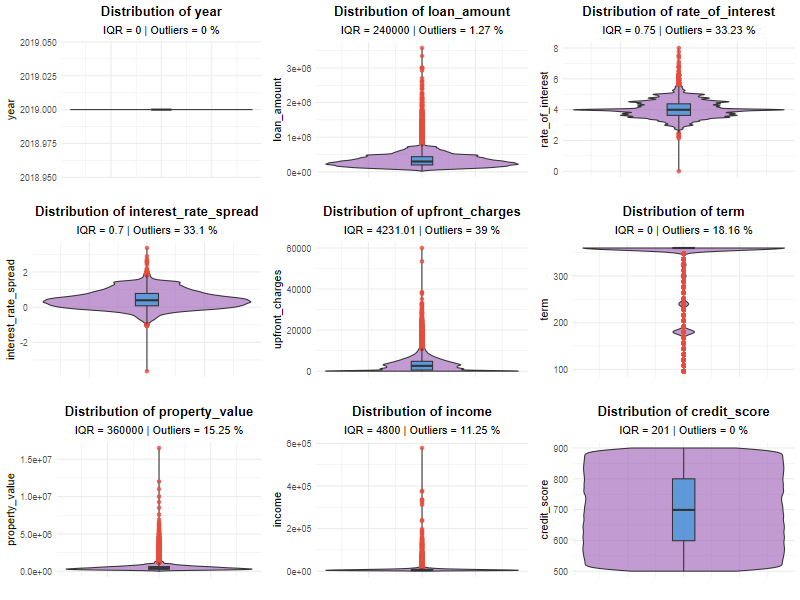

In [13]:
if(length(numeric_cols) > 0) {
  # Create a function for advanced boxplots
  advanced_boxplot <- function(data, variable) {
    # Calculate outlier bounds
    q1 <- quantile(data[[variable]], 0.25, na.rm = TRUE)
    q3 <- quantile(data[[variable]], 0.75, na.rm = TRUE)
    iqr <- q3 - q1
    lower_bound <- q1 - 1.5 * iqr
    upper_bound <- q3 + 1.5 * iqr
    
    # Calculate percentage of outliers
    outliers <- data[[variable]][data[[variable]] < lower_bound | data[[variable]] > upper_bound]
    outlier_pct <- length(outliers) / length(na.omit(data[[variable]])) * 100
    
    p <- ggplot(data, aes_string(y = variable, x = 1)) +
      geom_violin(fill = "#9b59b6", alpha = 0.6) +
      geom_boxplot(width = 0.1, fill = "#3498db", alpha = 0.7, outlier.color = "#e74c3c") +
      labs(
        title = paste("Distribution of", variable),
        subtitle = paste(
          "IQR =", round(iqr, 2),
          "| Outliers =", round(outlier_pct, 2), "%"
        ),
        y = variable, x = ""
      ) +
      theme_minimal() +
      theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
      )
    
    return(p)
  }
  
  # Create boxplots for the first 9 numeric variables
  plot_list <- lapply(numeric_cols[1:min(9, length(numeric_cols))], 
                     function(col) advanced_boxplot(loan_data, col))
  do.call(grid.arrange, c(plot_list, ncol = 3))
}